In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from dataloaders import MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.layers import IntegrateAndFireLayer
from spiking.learning import STDP
from spiking.competition import WinnerTakesAll
from spiking.evaluation import SpikingClassifierEvaluator
from spiking.threshold import NormalInitialization, FalezAdaptation

from visualization import SpikesVisualization

In [3]:
dataloader = MnistSpikesDataloader("./data/mnist-subset", 'train')
validation_dataloader = MnistSpikesDataloader("./data/mnist-subset", 'test')
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")

max_input_spikes = 1568


In [21]:
def train(model: IntegrateAndFireLayer, num_epochs: int = 12, plot_rate: int = 4):
    for epoch_idx in tqdm.trange(1, num_epochs + 1):
        for batch_idx, (spikes, label, times) in enumerate(dataloader.iterate(batch_size=1), start=1):
            membrane_potentials = []
            membrane_potentials_times = []

            for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_x, max_y, max_z)):
                output_spike = model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)

                if np.any(output_spike == 1.0):
                    membrane_potentials.append([
                        neuron.threshold if output_spike[neuron_idx] else neuron.membrane_potential
                        for neuron_idx, neuron in enumerate(model.neurons)
                    ])
                    membrane_potentials_times.append(current_time)
                membrane_potentials.append([neuron.membrane_potential for neuron in model.neurons])
                membrane_potentials_times.append(current_time)

            pre_spike_times = times.flatten()
            model.backward(pre_spike_times)
            post_spike_times = model.spike_times

            if epoch_idx % plot_rate == 0 and batch_idx <= 3:
                SpikesVisualization.plot_pre_post_spikes(
                    pre_spike_times,
                    post_spike_times,
                    title=f"Pre-synaptic vs Post-synaptic. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}",
                    unique_colors=True
                )
                # SpikesVisualization.plot_multiple_membrane_potentials(
                #     membrane_potentials,
                #     membrane_potentials_times,
                #     title=f"Membrane Potential Over Time. Epoch {epoch_idx} - Batch {batch_idx} - Label {label}"
                # )

            model.reset()


def eval_snn(model: IntegrateAndFireLayer):
    evaluator = SpikingClassifierEvaluator(model, dataloader, validation_dataloader, shape=(max_x, max_y, max_z))
    print(f"{evaluator.X_train.shape = }, {evaluator.y_train.shape = }")
    print(f"{evaluator.X_test.shape = }, {evaluator.y_test.shape = }")

    evaluator.plot_reduced_dataset("train")
    evaluator.plot_reduced_dataset("val")
    evaluator.train_classifier_and_compute_metrics()


def visualize_neurons_weights(model: IntegrateAndFireLayer, num_neurons: int):
    for i in range(num_neurons):
        img = model.neurons[i].weights.reshape((max_z, max_x, max_y))
        plt.title(f"Weights {i}")
        plt.axis("off")
        plt.subplot(1, 2, 1)
        plt.imshow(img[0, :, :], cmap='grey')
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(img[1, :, :], cmap='grey')
        plt.axis("off")
        plt.show()

In [7]:
stdp = STDP()
wta = WinnerTakesAll()
min_threshold = 0.5
threshold_initialization = NormalInitialization(min_threshold=min_threshold)
threshold_adaptation = FalezAdaptation(min_threshold=min_threshold, threshold_learning_rate=2e-2, target_timestamp=0.7)

In [8]:
model = IntegrateAndFireLayer(
    num_inputs=max_input_spikes,
    num_outputs=24,
    learning_mechanism=stdp,
    competition_mechanism=wta,
    threshold=0.8,
    refractory_period=np.inf,
    threshold_initialization=threshold_initialization,
    threshold_adaptation=threshold_adaptation,
)

 25%|██▌       | 3/12 [00:27<01:22,  9.20s/it]

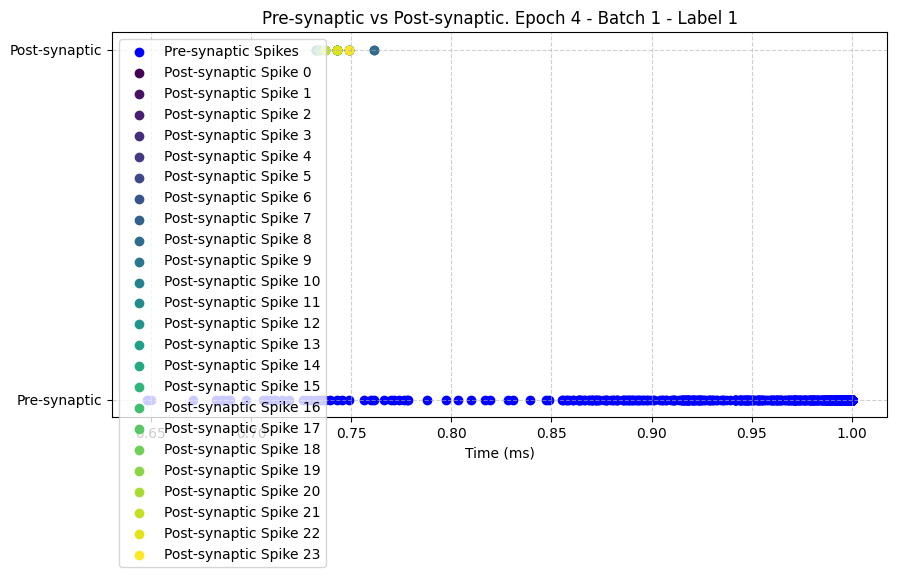

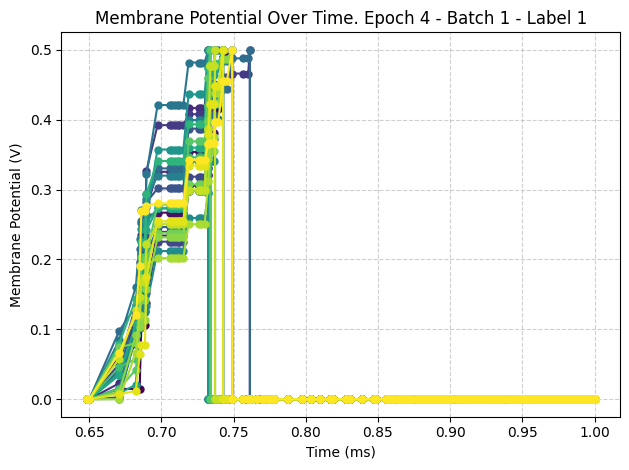

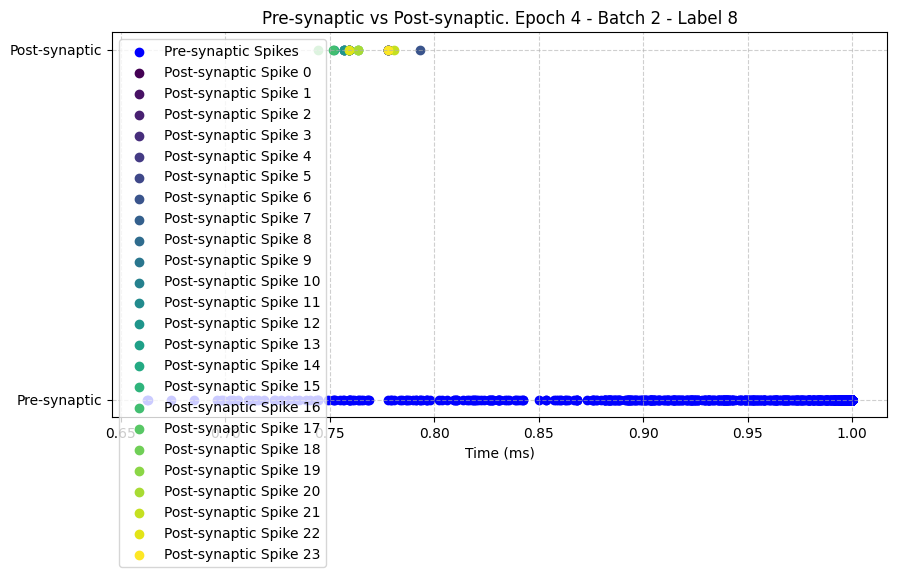

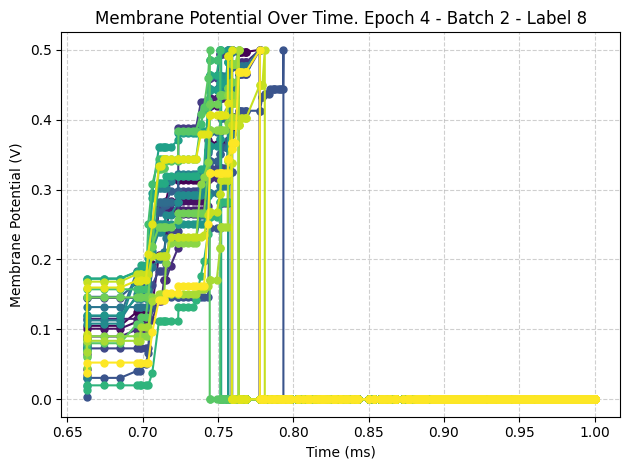

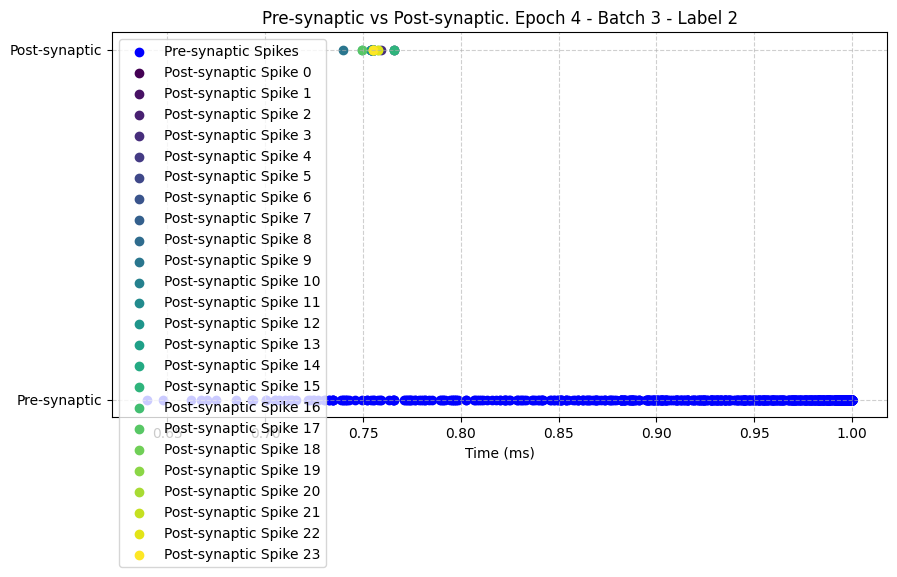

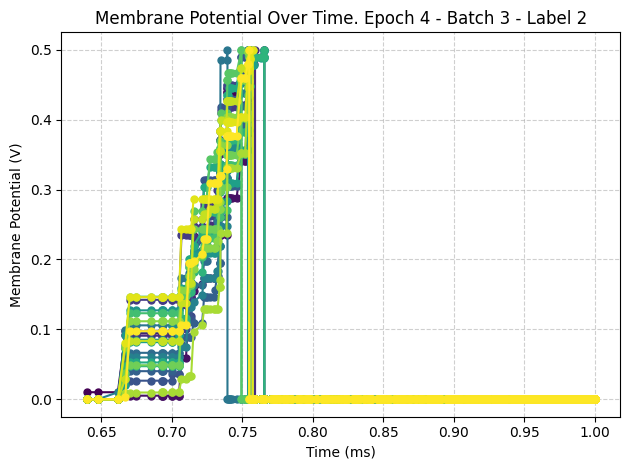

 58%|█████▊    | 7/12 [01:06<00:48,  9.67s/it]

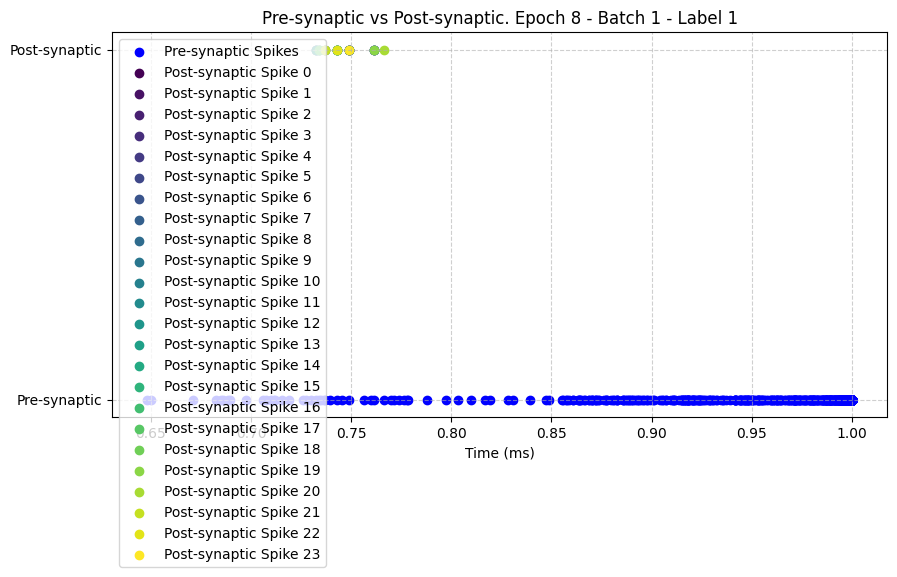

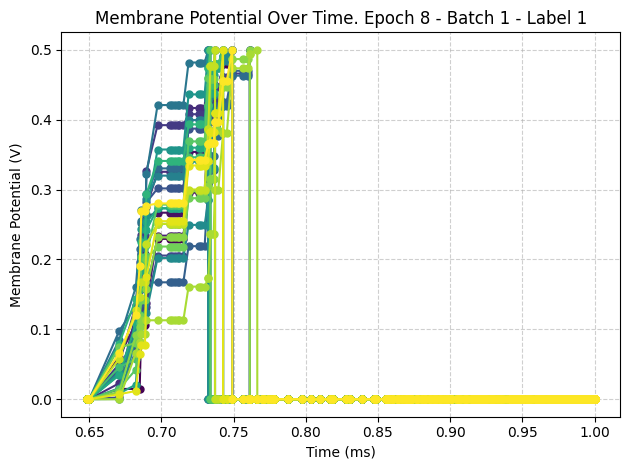

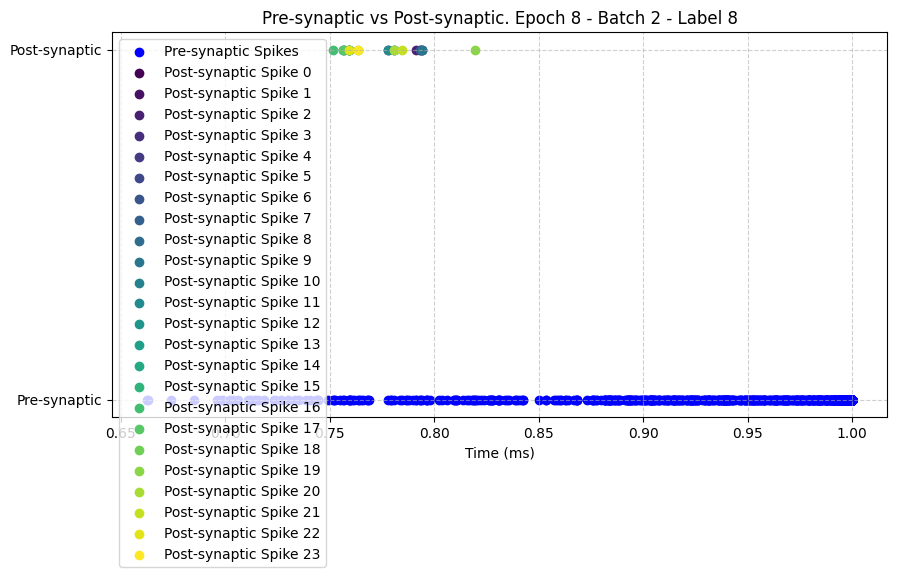

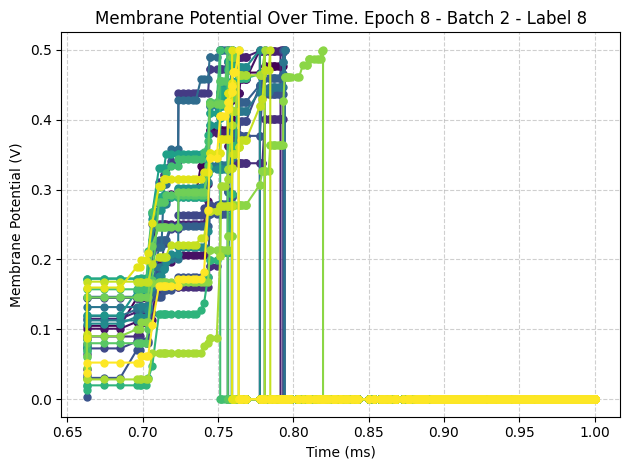

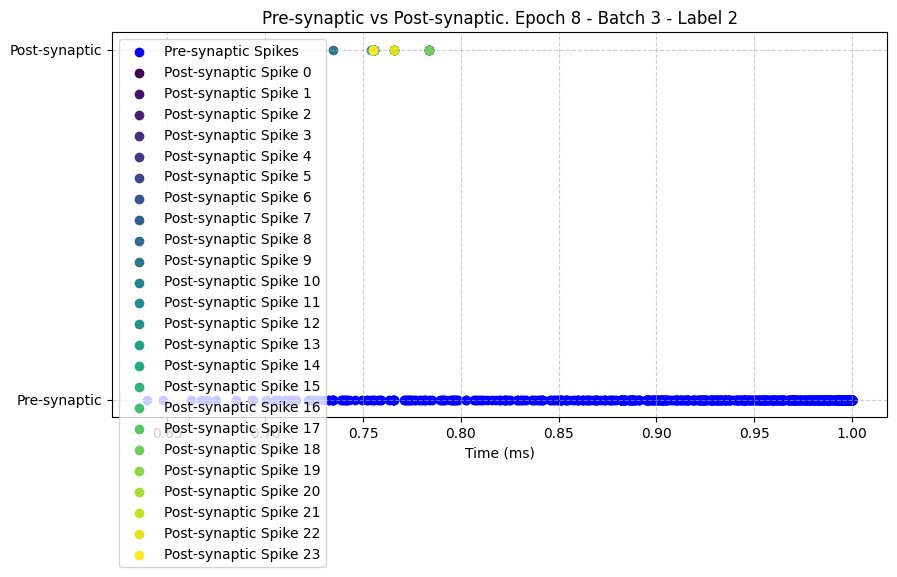

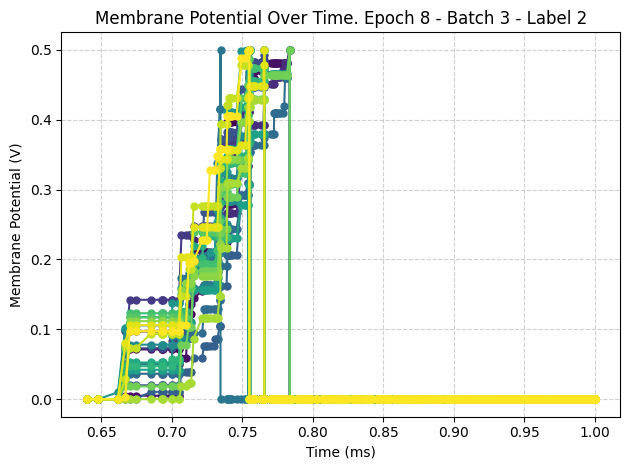

 92%|█████████▏| 11/12 [01:46<00:09,  9.79s/it]

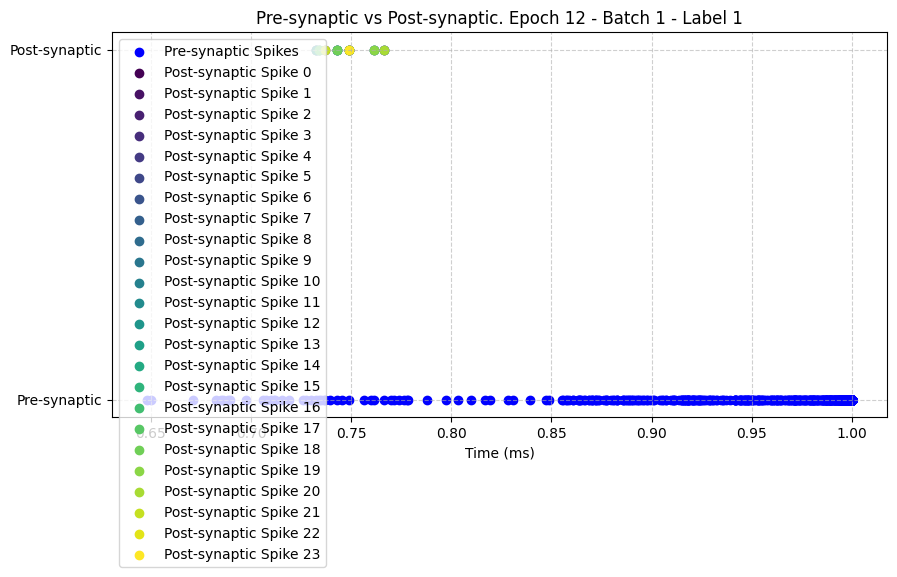

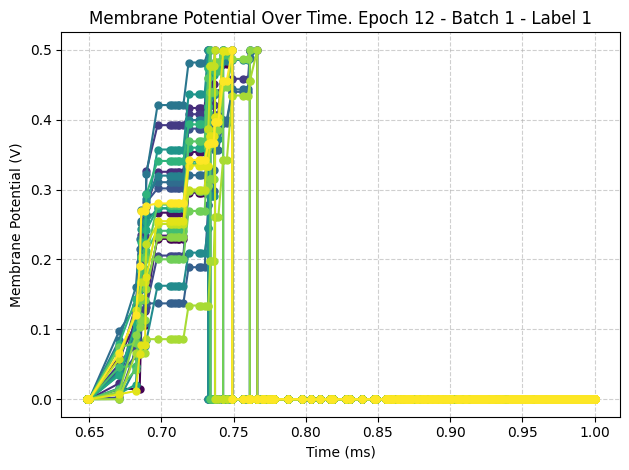

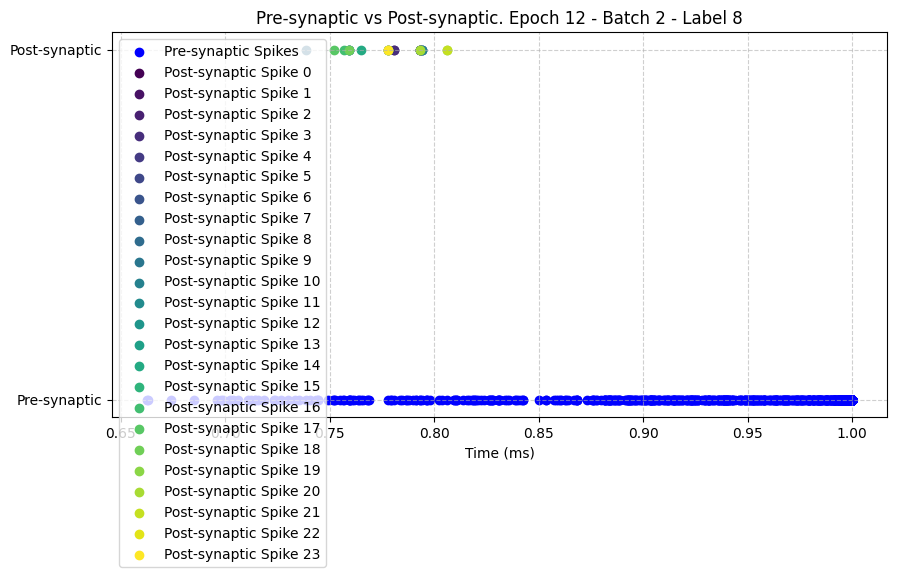

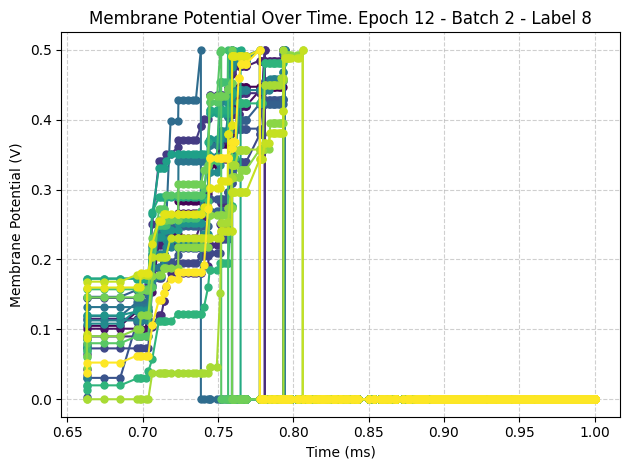

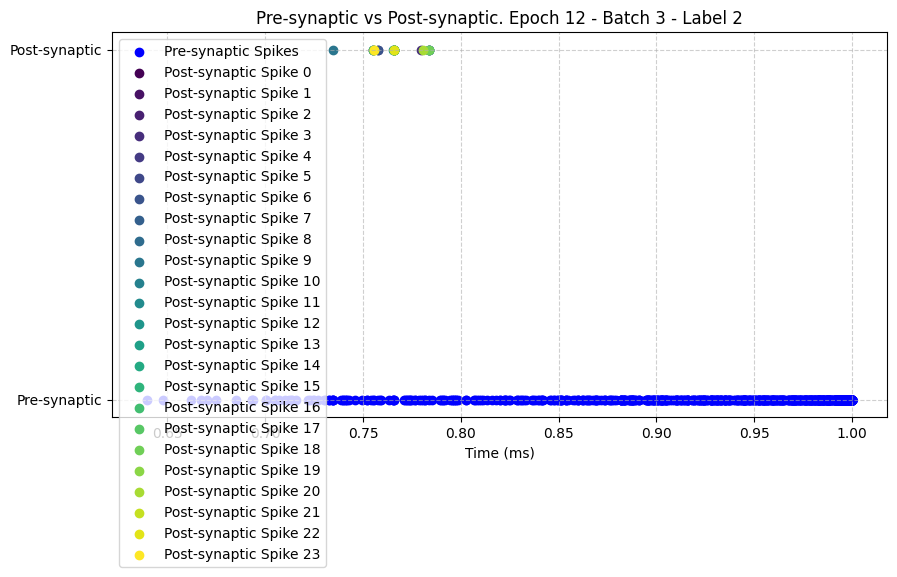

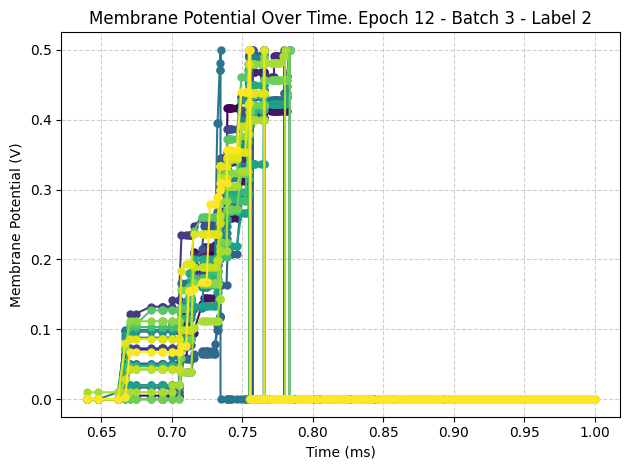

100%|██████████| 12/12 [01:57<00:00,  9.79s/it]


In [9]:
train(model, num_epochs=12)

evaluator.X_train.shape = (600, 24), evaluator.y_train.shape = (600,)
evaluator.X_test.shape = (100, 24), evaluator.y_test.shape = (100,)


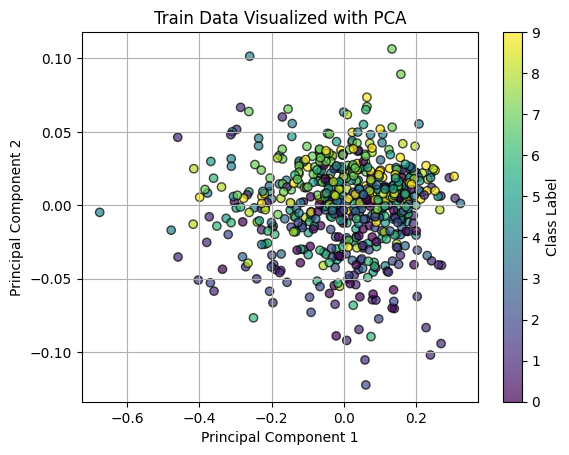

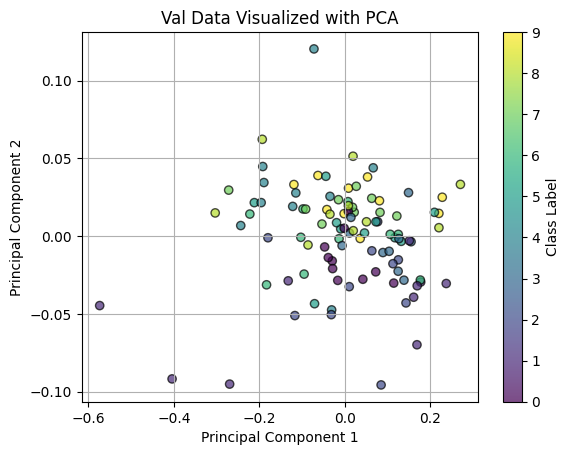

Train accuracy: 0.5433333333333333
Accuracy: 0.43
Precision: 0.39
Recall: 0.43
F1 Score: 0.40


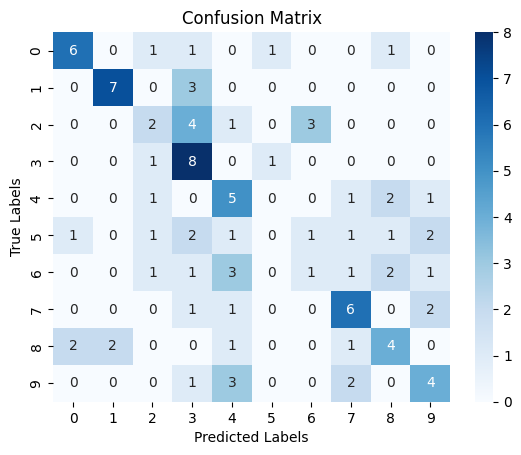

In [10]:
eval_snn(model)

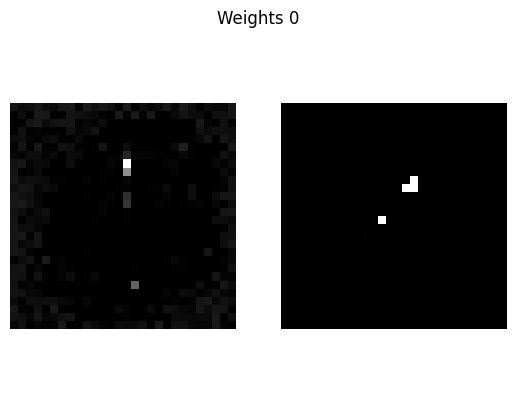

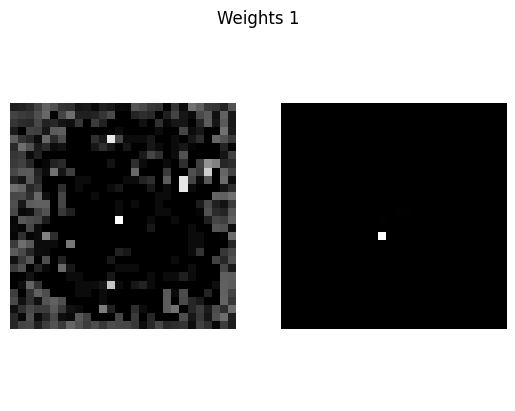

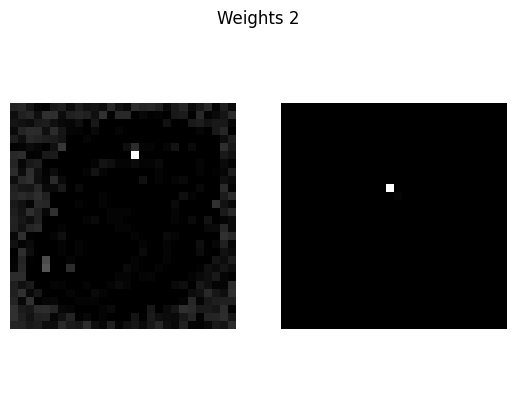

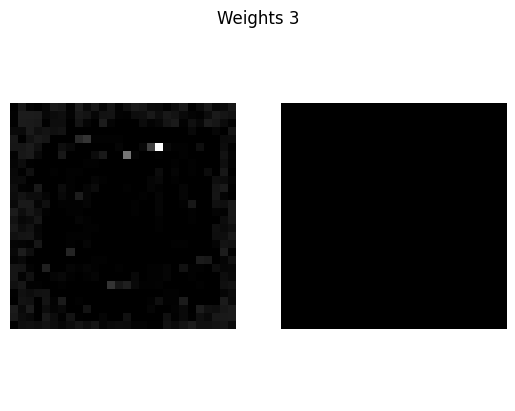

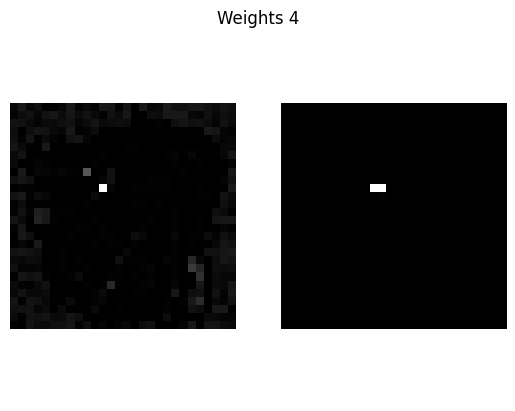

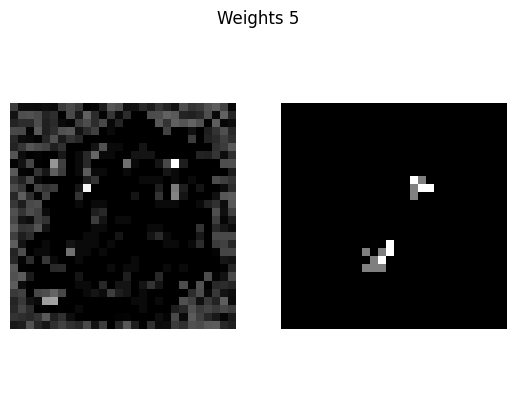

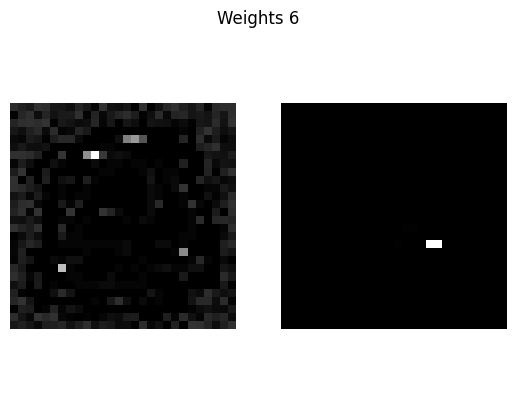

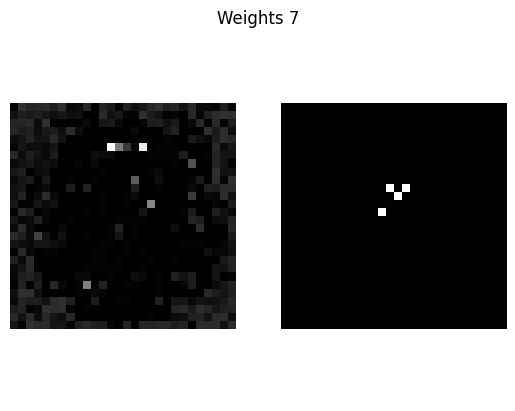

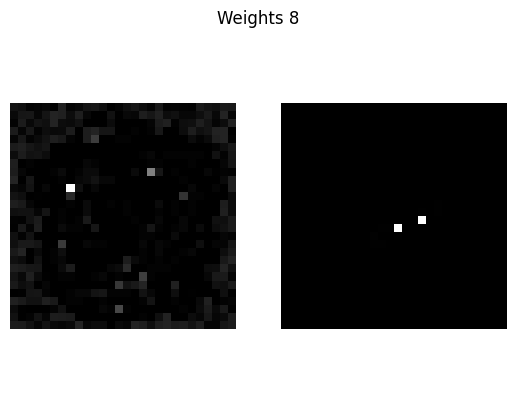

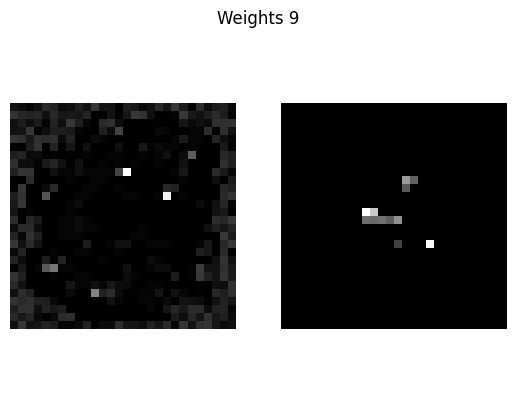

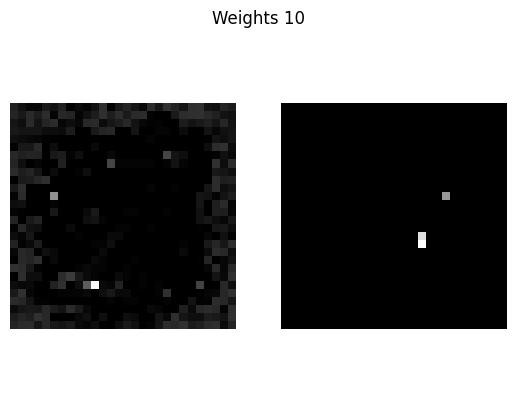

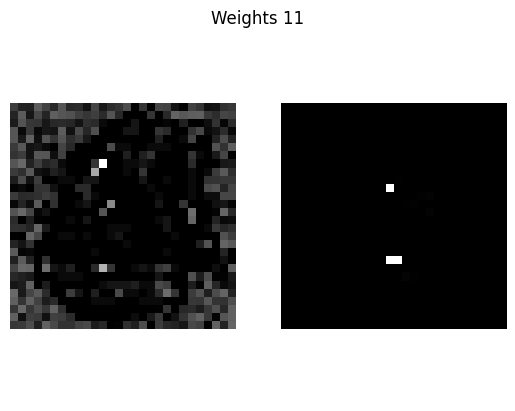

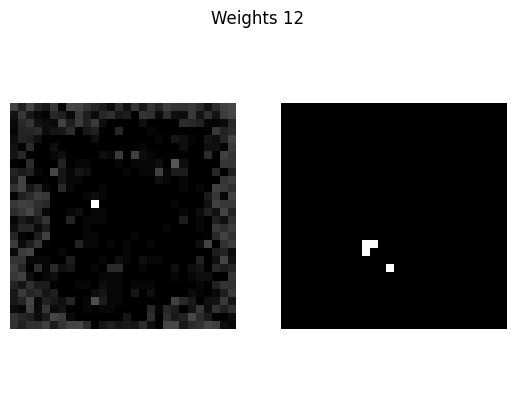

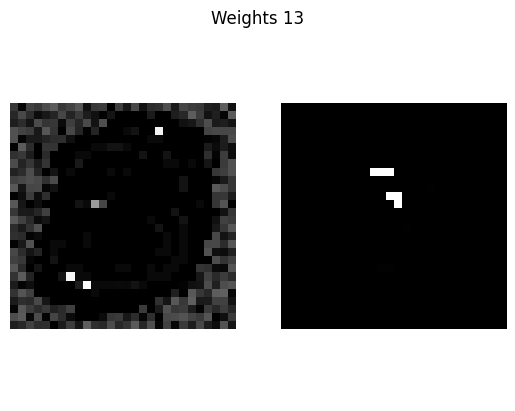

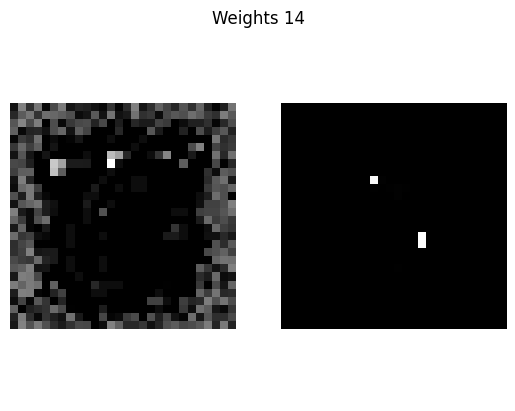

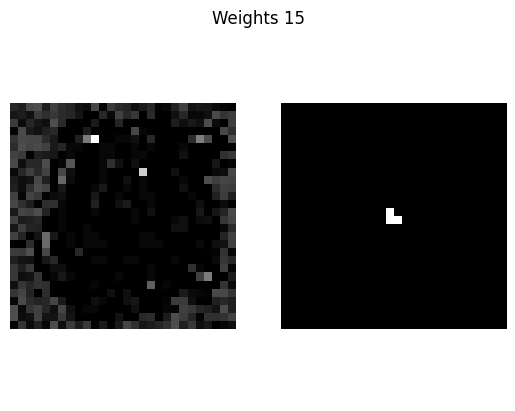

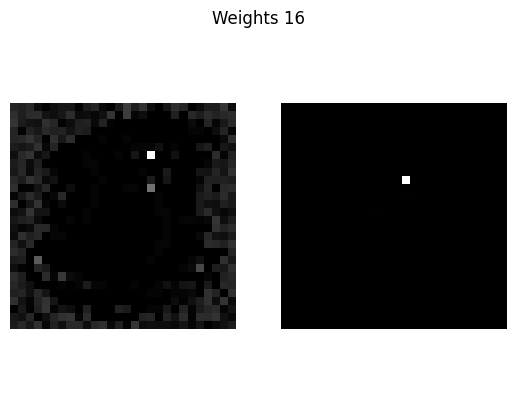

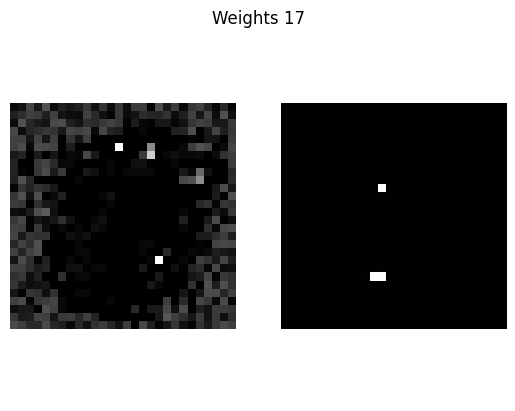

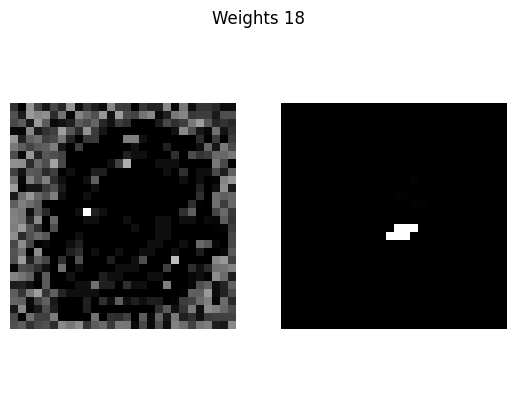

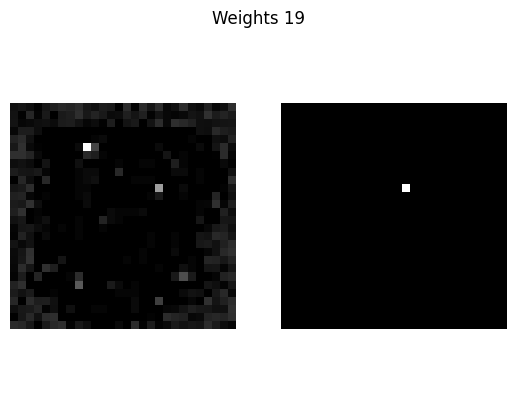

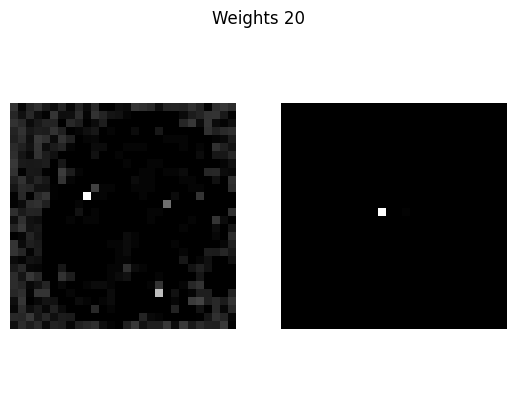

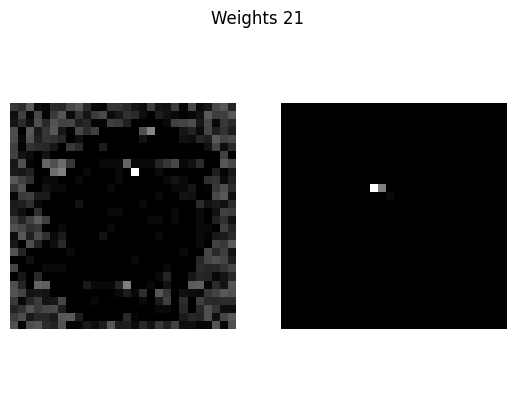

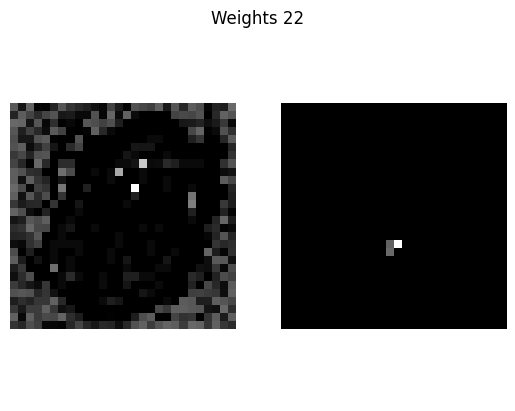

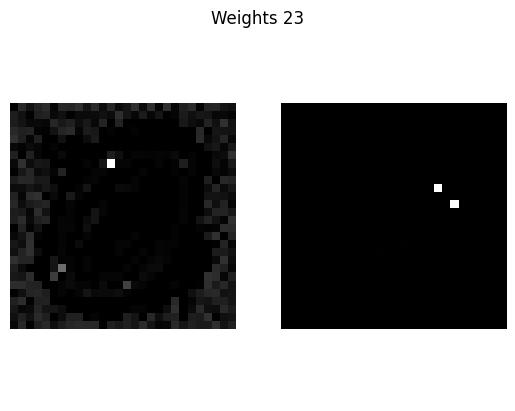

In [11]:
visualize_neurons_weights(model, num_neurons=24)

In [12]:
model2 = IntegrateAndFireLayer(
    num_inputs=max_input_spikes,
    num_outputs=24,
    learning_mechanism=stdp,
    competition_mechanism=wta,
    threshold=8.0,
    refractory_period=np.inf,
    threshold_initialization=threshold_initialization,
    threshold_adaptation=threshold_adaptation,
)

 25%|██▌       | 3/12 [00:28<01:25,  9.55s/it]

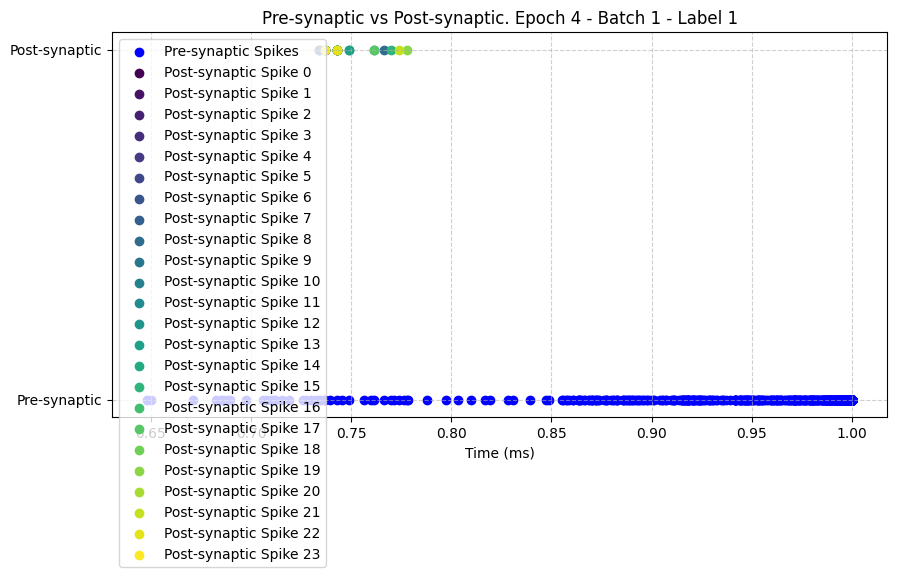

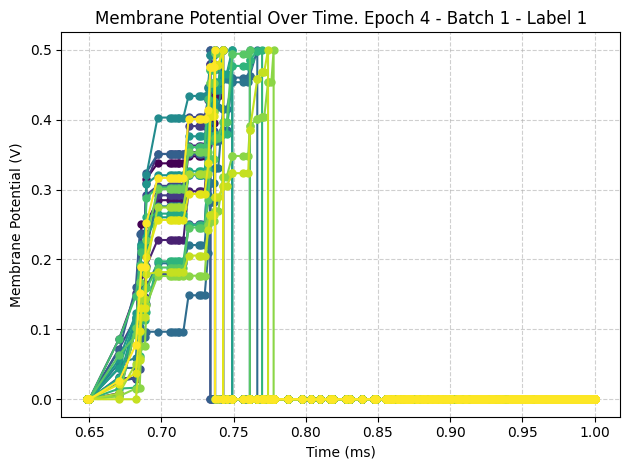

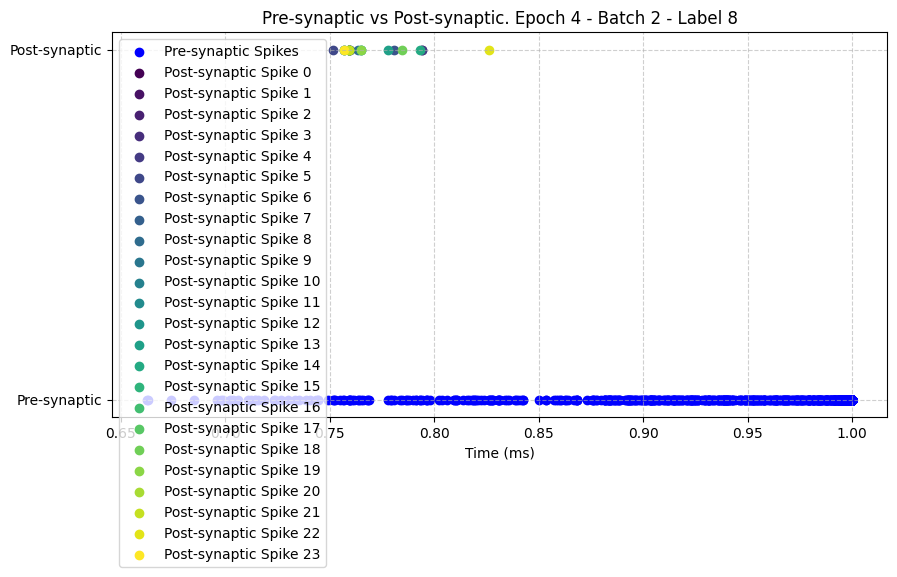

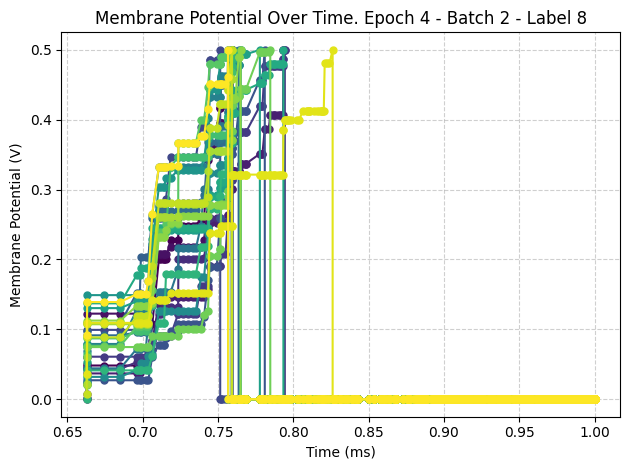

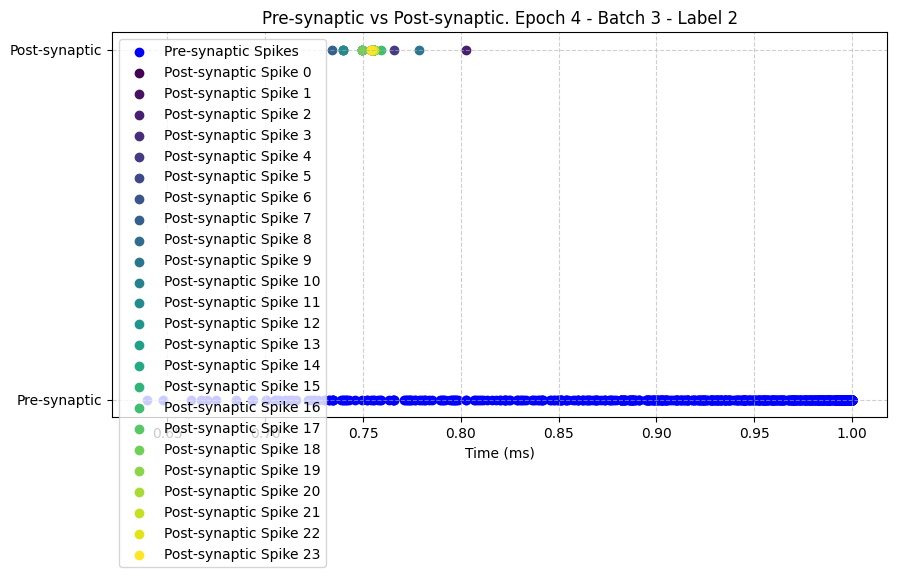

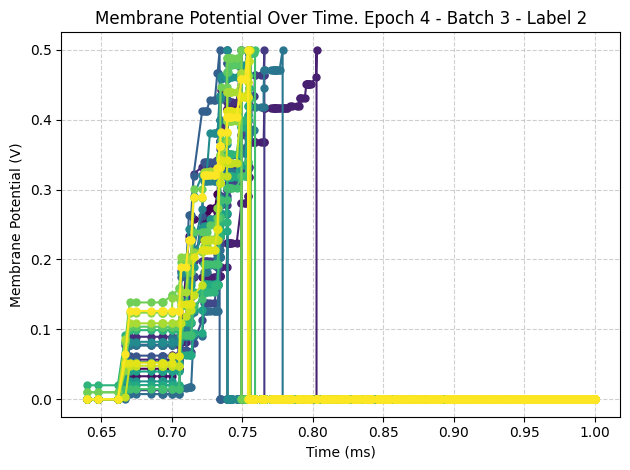

 58%|█████▊    | 7/12 [01:08<00:48,  9.63s/it]

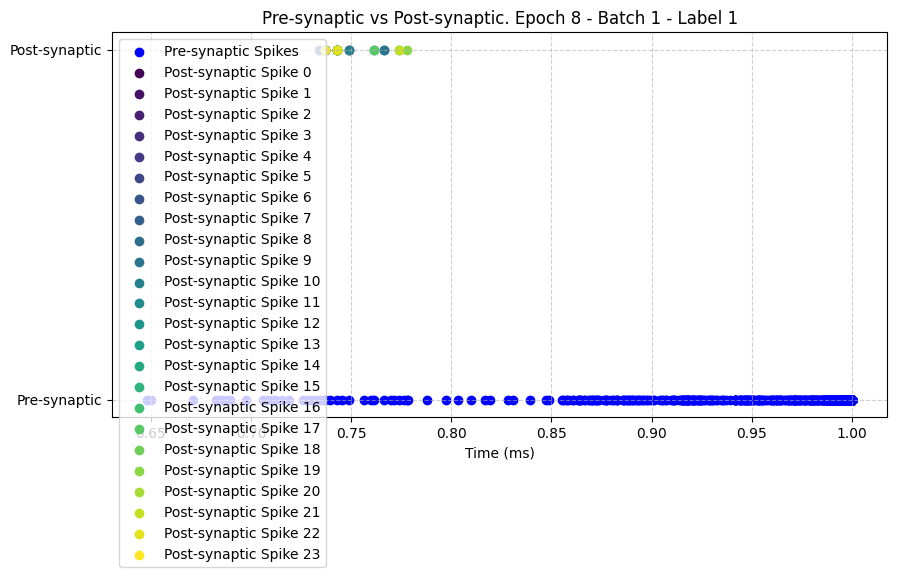

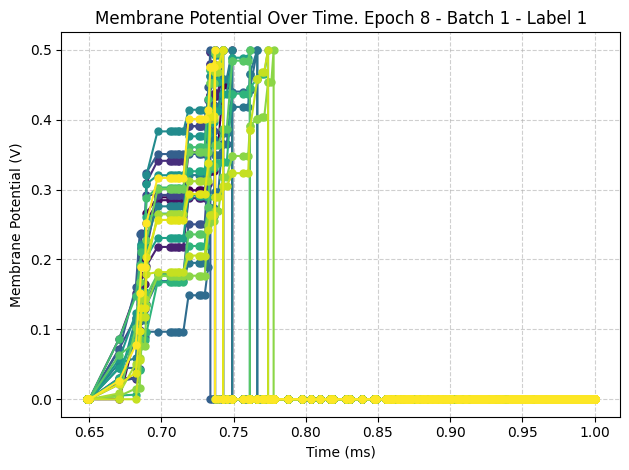

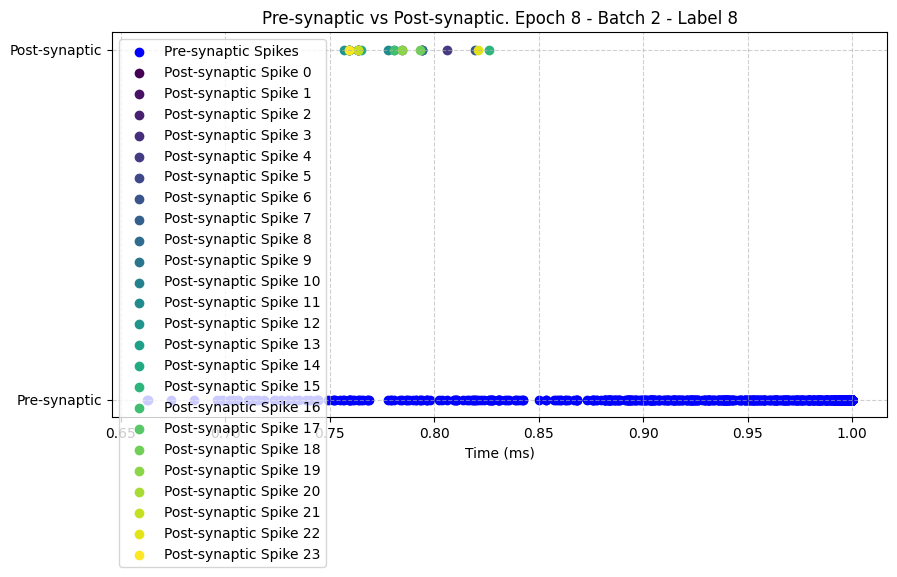

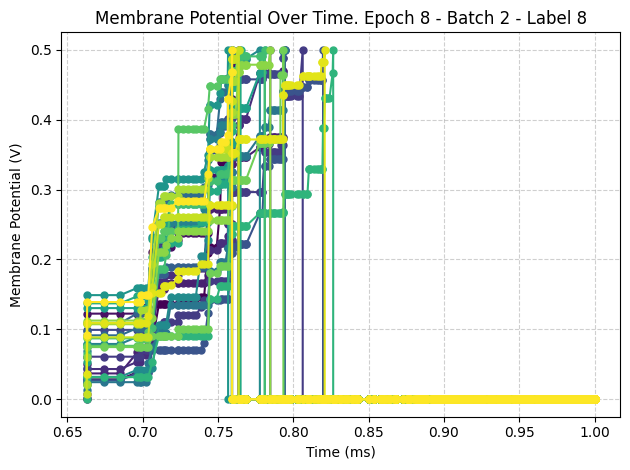

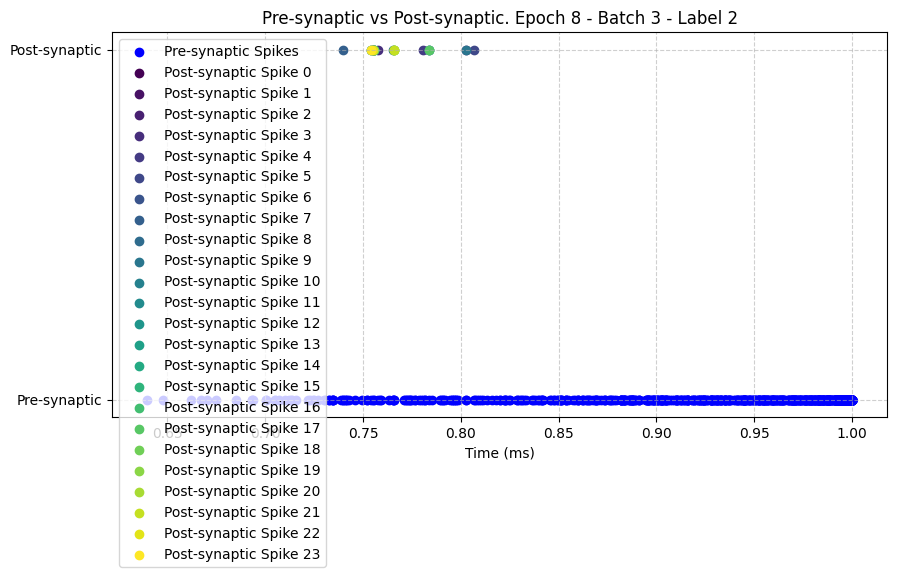

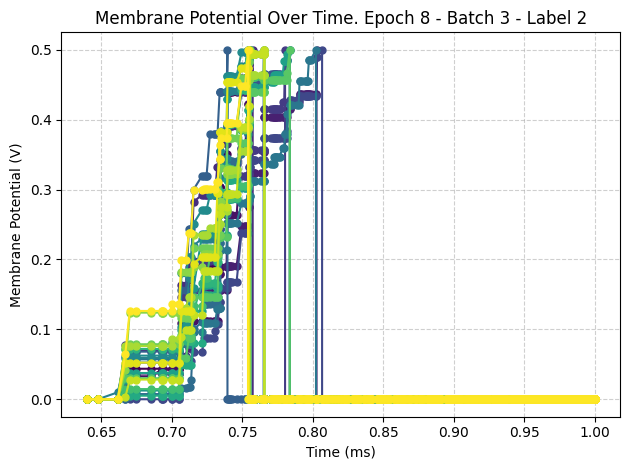

 92%|█████████▏| 11/12 [01:47<00:09,  9.64s/it]

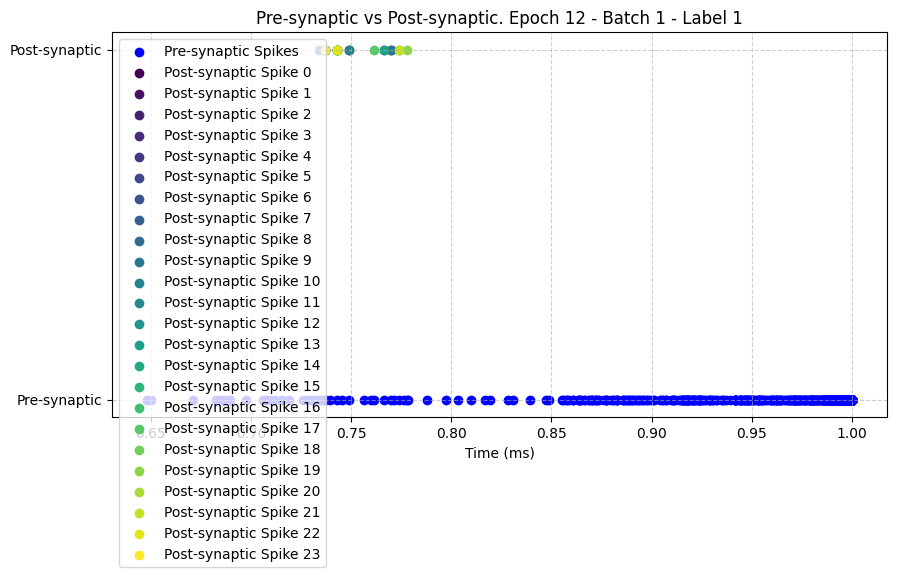

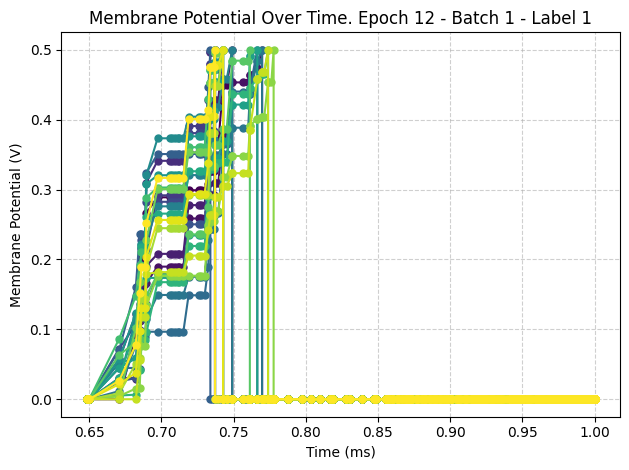

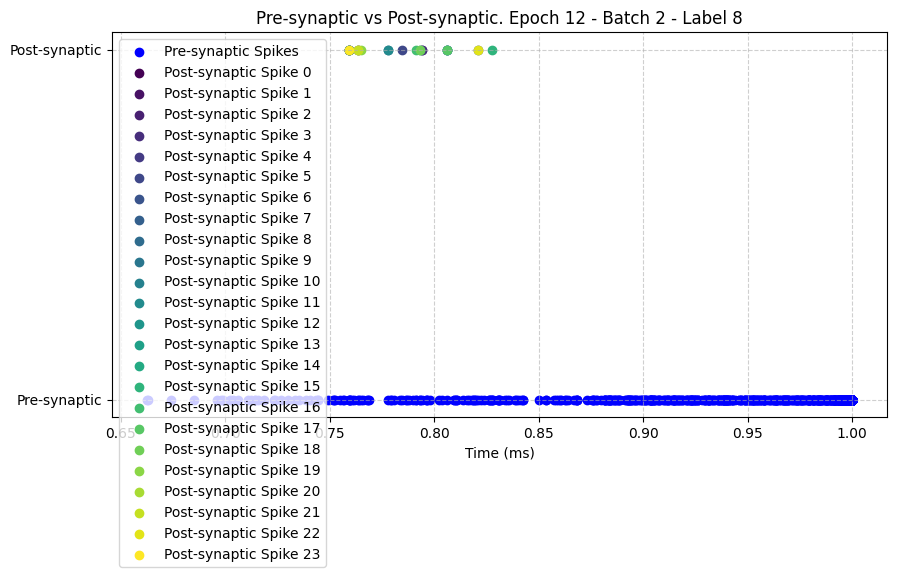

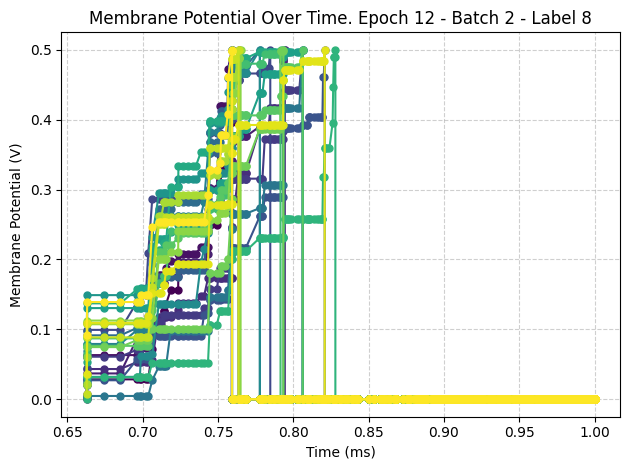

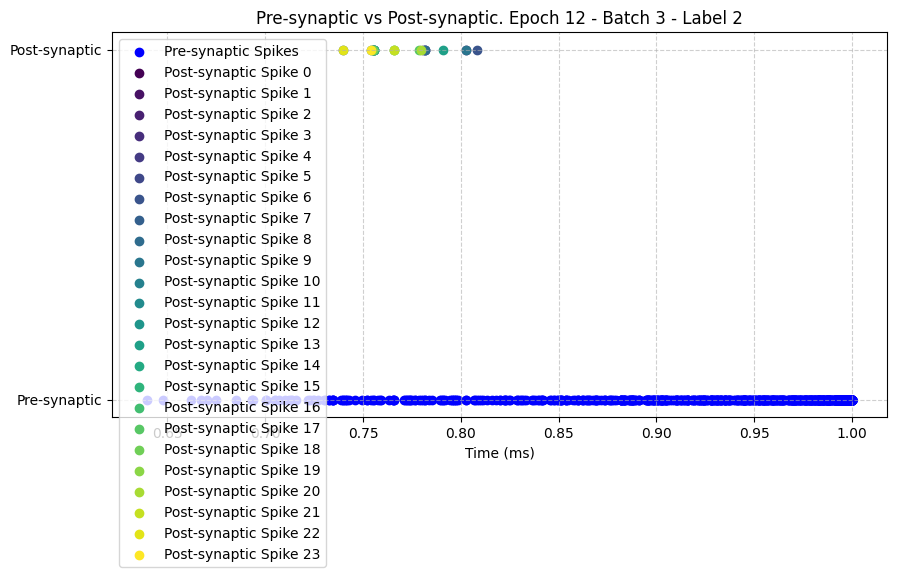

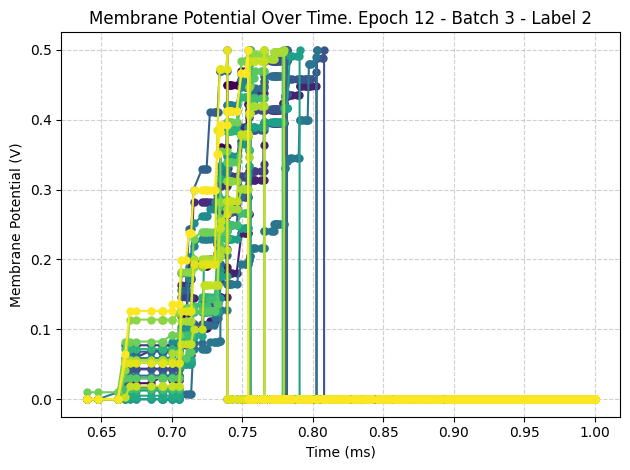

100%|██████████| 12/12 [01:57<00:00,  9.82s/it]


In [14]:
train(model2, num_epochs=12)

evaluator.X_train.shape = (600, 24), evaluator.y_train.shape = (600,)
evaluator.X_test.shape = (100, 24), evaluator.y_test.shape = (100,)


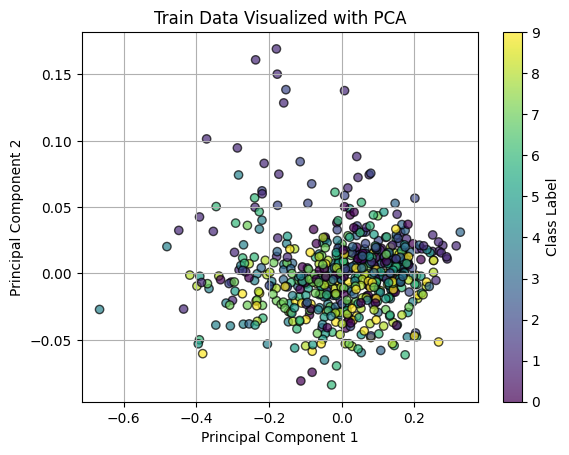

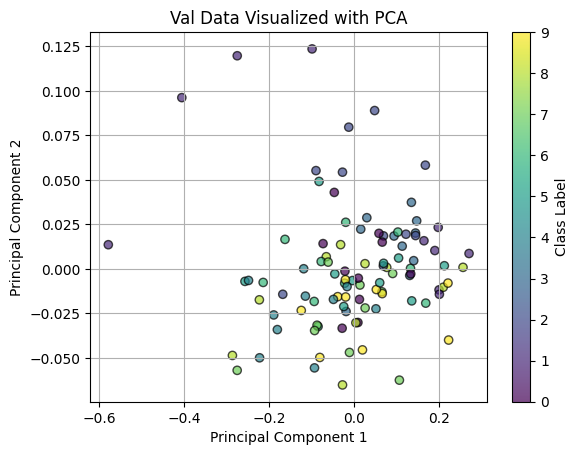

Train accuracy: 0.5416666666666666
Accuracy: 0.47
Precision: 0.49
Recall: 0.47
F1 Score: 0.44


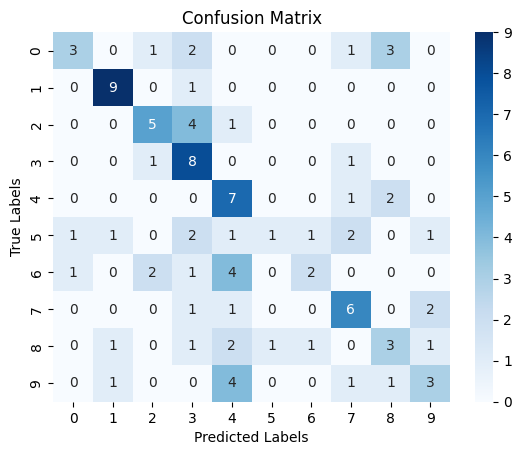

In [15]:
eval_snn(model2)

In [22]:
threshold_adaptation = FalezAdaptation(min_threshold=min_threshold, threshold_learning_rate=1e-3, target_timestamp=0.8)

model3 = IntegrateAndFireLayer(
    num_inputs=max_input_spikes,
    num_outputs=24,
    learning_mechanism=stdp,
    competition_mechanism=wta,
    threshold=8.0,
    refractory_period=np.inf,
    threshold_initialization=threshold_initialization,
    threshold_adaptation=threshold_adaptation,
)

 25%|██▌       | 3/12 [00:59<02:59, 19.93s/it]

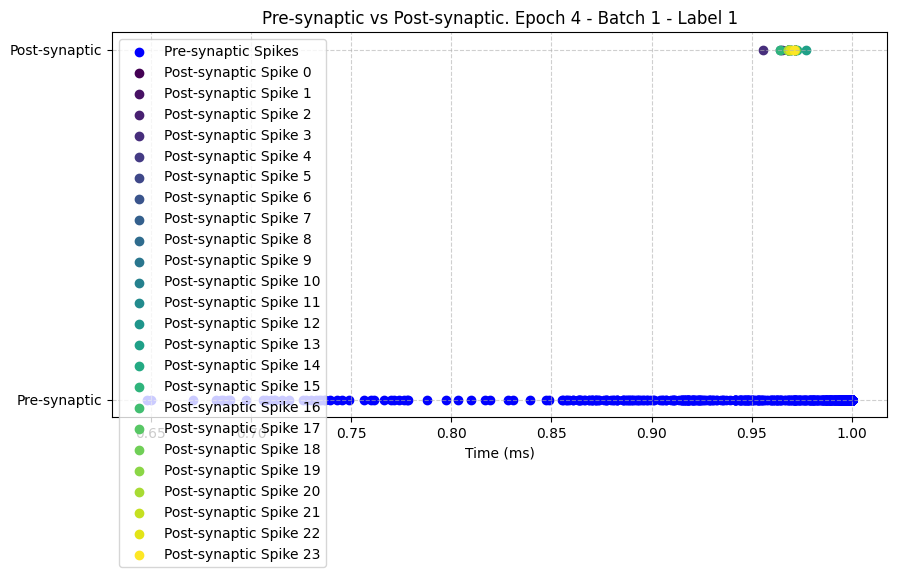

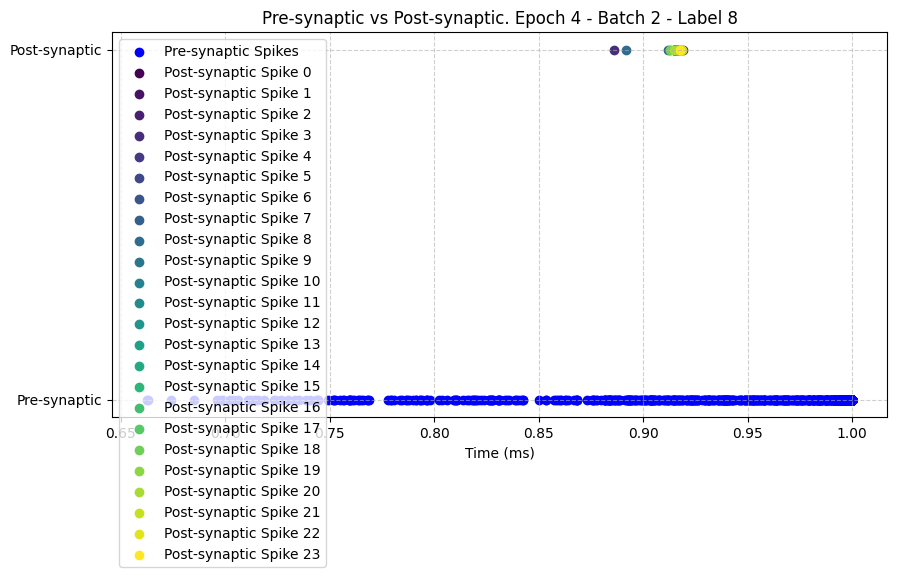

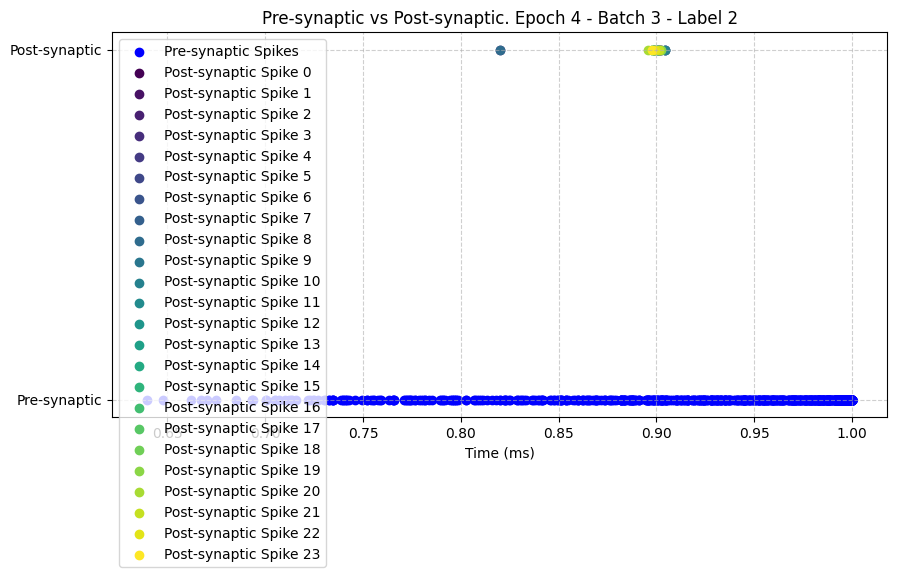

 58%|█████▊    | 7/12 [02:17<01:37, 19.41s/it]

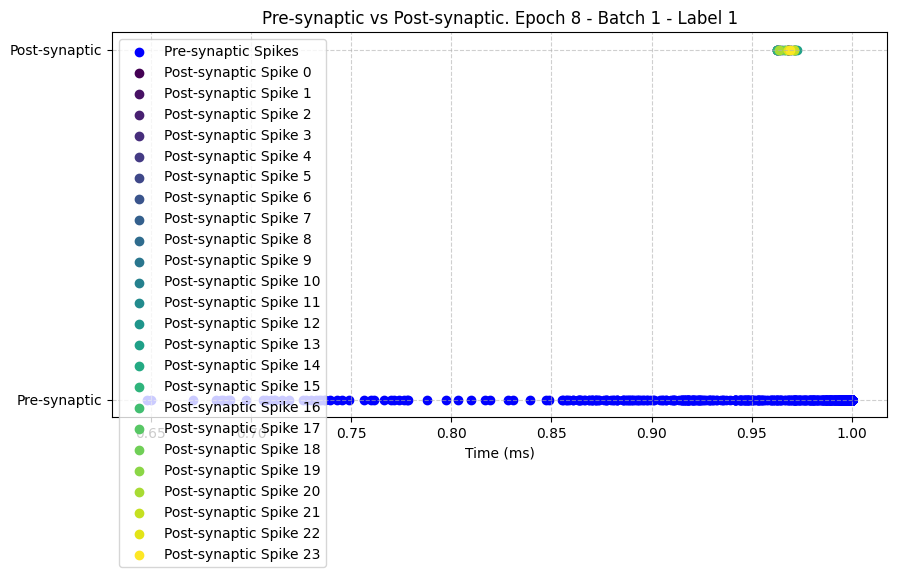

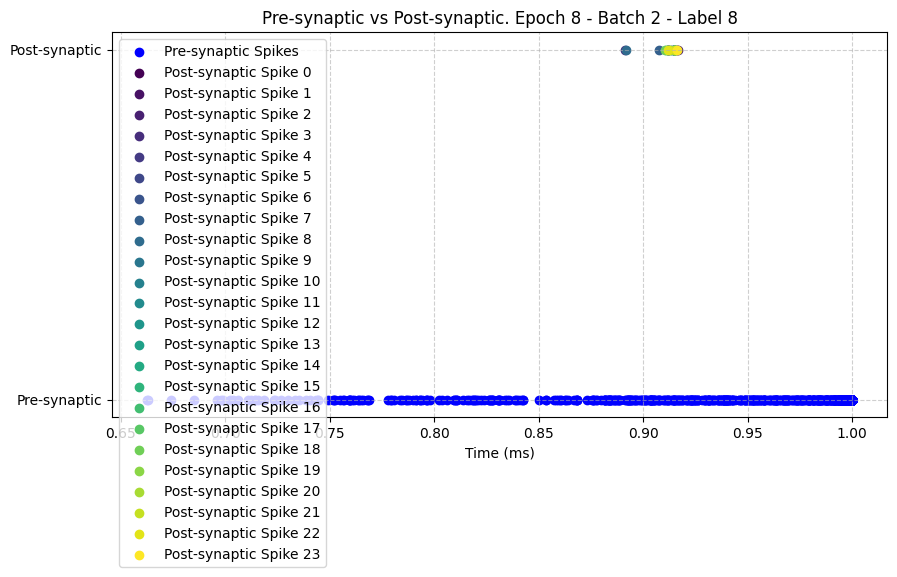

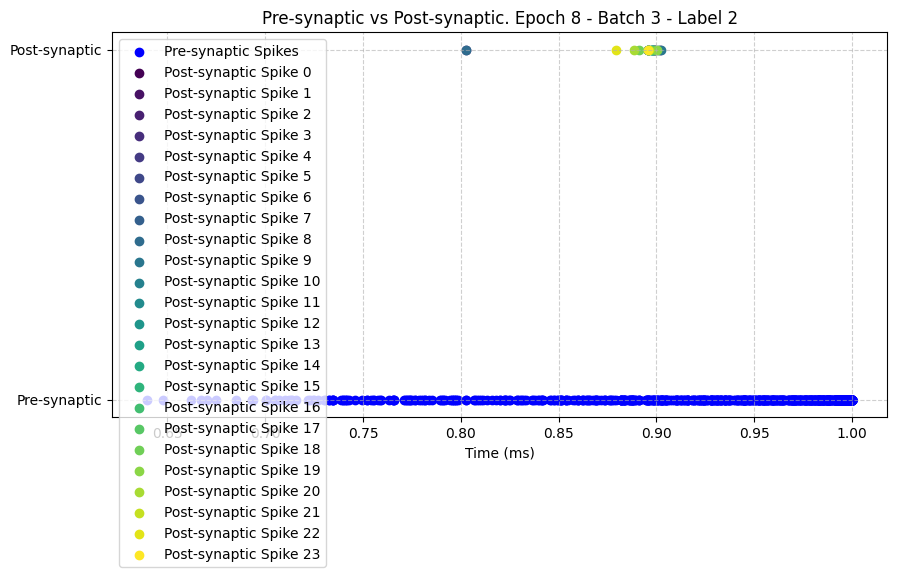

 92%|█████████▏| 11/12 [03:31<00:18, 18.67s/it]

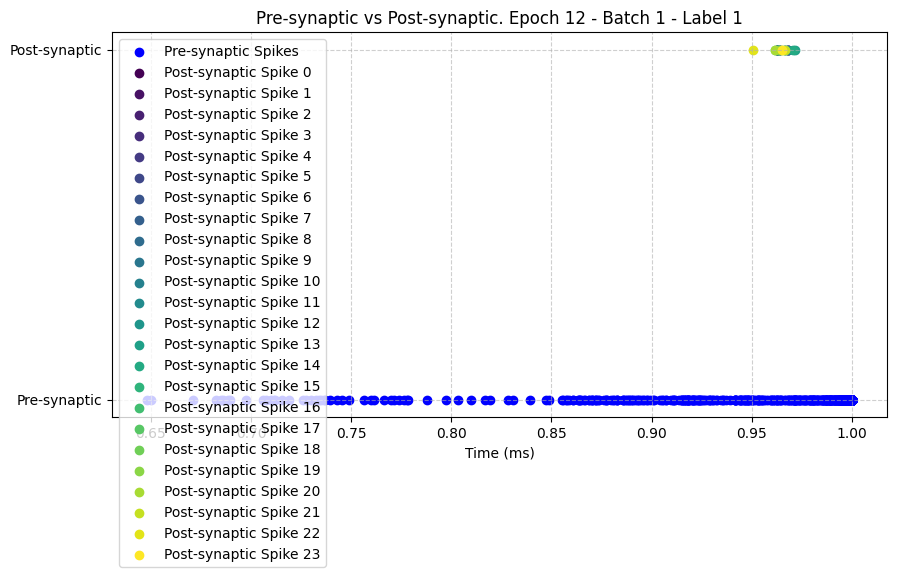

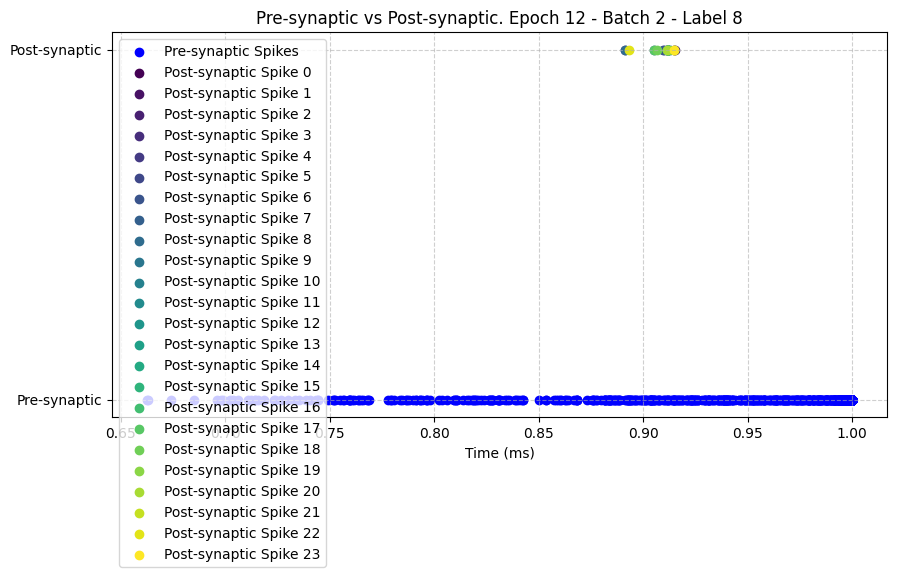

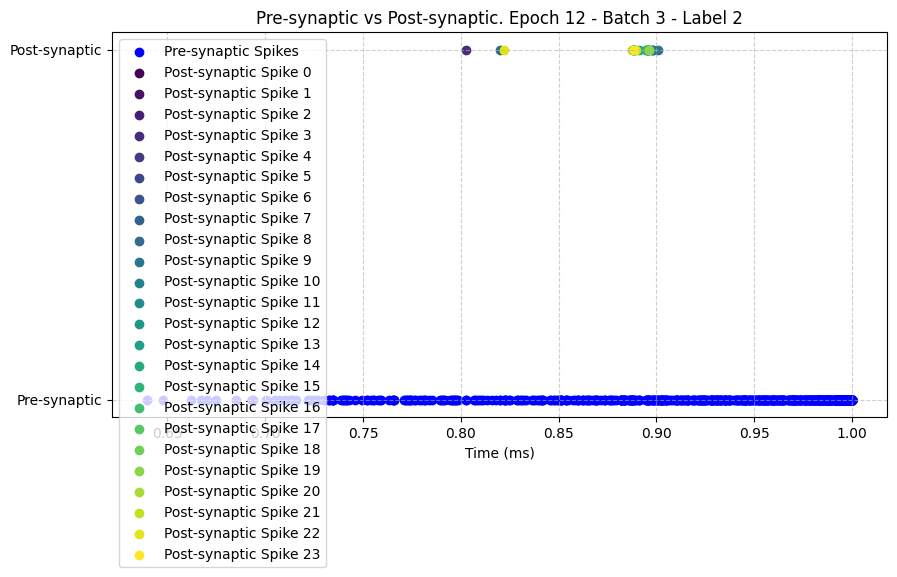

100%|██████████| 12/12 [03:50<00:00, 19.23s/it]


In [23]:
train(model3, num_epochs=12)

evaluator.X_train.shape = (600, 24), evaluator.y_train.shape = (600,)
evaluator.X_test.shape = (100, 24), evaluator.y_test.shape = (100,)


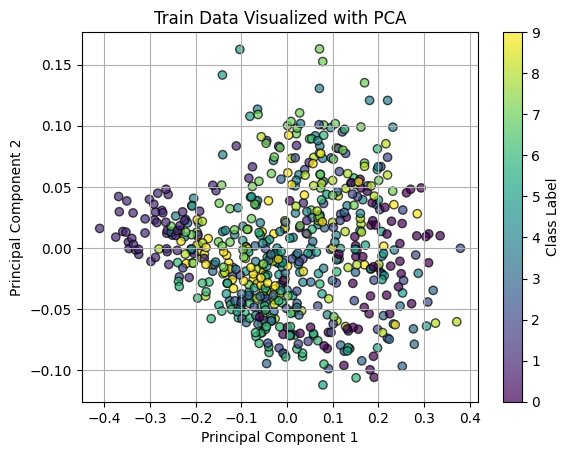

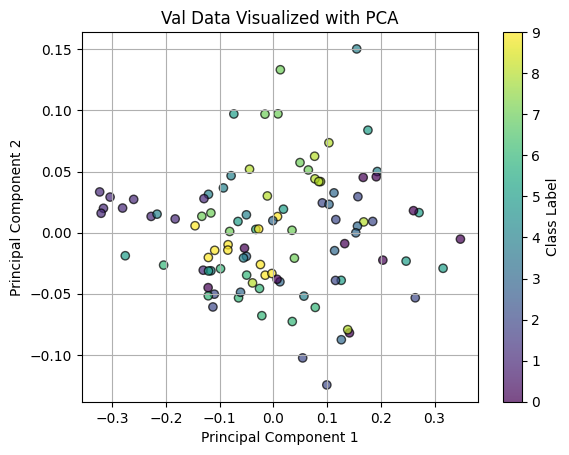

Train accuracy: 0.385
Accuracy: 0.36
Precision: 0.27
Recall: 0.36
F1 Score: 0.29


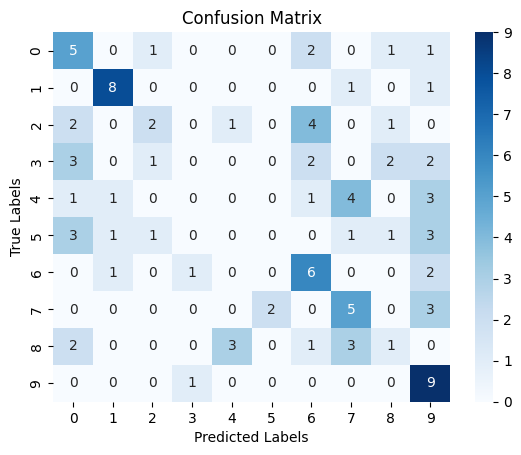

In [24]:
eval_snn(model3)